In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 400)

# NPS

In [2]:
df_nps = pd.read_csv("data/NPS.csv")
df_nps = df_nps[['email', 'How often do you use a dry cleaner and/or launderette?', 'file']]
df_nps.columns = ['email', 'NPS_frequency', 'file']

translations = {'Toutes les deux semaines': 'Bi-Weekly',
               'Chaque mois': 'Monthly',
               'Moins que chaque trimestre': 'Less than quarterly',
               'Chaque trimestre': 'Quarterly',
               'Chaque semaine': 'Weekly',
               'Weniger oft': 'Less than quarterly',
               'VierteljÃ¤hrlich': 'Quarterly',
               'ZweiwÃ¶chentlich': 'Bi-Weekly',
               'Monatlich': 'Monthly',
               'WÃ¶chentlich': 'Weekly'}

sorting = {'Weekly': '0_Weekly',
          'Bi-Weekly': '1_Bi-Weekly',
          'Monthly': '2_Monthly',
          'Quarterly': '3_Quarterly',
          'Less than quarterly': '4_Less than quarterly'}

df_nps.loc[df_nps.file.isin(['DE.csv', 'FR.csv']), 'NPS_frequency'] = df_nps.NPS_frequency.map(translations)
df_nps.NPS_frequency = df_nps.NPS_frequency.map(sorting)
df_nps = df_nps[['email', 'NPS_frequency']]

# Item Segmentation

In [77]:
df = pd.read_csv("data/items.csv")
df_orders = pd.read_csv("data/order_churn_data.csv")
df = df.merge(df_orders[["customer_db_id", "email", "order_id", "aov", "order_state", "order_created_datetime", "frequency"]])
df = df.merge(df_nps, on='email', how='left')
df = df.loc[df.order_state == "completed"]

In [78]:
df.customer_db_id.nunique()

34417

In [79]:
df.sort_values(["customer_db_id", "order_created_datetime"]).head()

,product_id,order_id,order_date,quantity,price_per_unit,segmentation,category,product_name,customer_db_id,email,aov,order_state,order_created_datetime,frequency,NPS_frequency
281055,GB-PRO-R8877223,GB-L-58332,2017-02-12 18:56:36,20,2.2,LA,drycleaning,Men's Shirt (on hanger),545b9a8bd2cde8871f009f9b,rotem+1@blueyonder.co.uk,24.930811,completed,2017-02-12 17:56:36,103.62500,NaN
279636,GB-PRO-R8877223,GB-R-13286,2017-01-01 17:16:04,5,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,alex.garner+1@gs.com,25.701746,completed,2017-01-01 16:16:03,12.53211,NaN
280003,GB-PRO-R8877223,GB-C-99067,2017-01-13 20:23:07,5,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,alex.garner+1@gs.com,25.701746,completed,2017-01-13 19:23:07,12.53211,NaN
280035,GB-PRO-R8877223,GB-G-36643,2017-01-14 22:52:27,5,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,alex.garner+1@gs.com,25.701746,completed,2017-01-14 21:52:26,12.53211,NaN
280741,GB-PRO-R8877223,GB-X-53507,2017-02-03 18:12:38,4,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,alex.garner+1@gs.com,25.701746,completed,2017-02-03 17:12:38,12.53211,NaN


In [80]:
df.groupby('product_name')['order_id'].count().sort_values(ascending=False).head()

product_name
Men's Shirt (on hanger)        39564
Shirt (on hanger)              32827
Bag of Folded Laundry (8kg)    24562
Trousers                       22408
Suit m/f (2 piece)             13509
Name: order_id, dtype: int64

# Group Products By Type

In [81]:
df_products = pd.read_csv("data/products.csv")
unique_prods = df_products.product_name.sort_values().unique().tolist()

In [82]:
len(unique_prods)

397

In [83]:
unique_prods

['#FINILALESSIVE Blouse',
 '#FINILALESSIVE Shirt (on hanger)',
 '#LAUNDRYLIBERATION SPECIAL Blouse',
 '#LAUNDRYLIBERATION SPECIAL Shirt (on hanger)',
 '#WÄSCHEREVOLUTION Blouse',
 '#WÄSCHEREVOLUTION Shirt (on hanger)',
 "1 Suit (2 pieces), 10 Men's Shirts on a hanger & 1 Tie",
 "10 Men's Shirt (on hanger) Bundle",
 '10 Shirt (On Hanger) Bundle',
 '10 Shirts (On Hanger) Bundle',
 '10 Shirts (on hanger)',
 '10 shirts on hanger',
 '10 t-shirts',
 "11 Men's Shirt (on hanger) Bundle",
 '11 Shirts (On Hanger) Bundle',
 '11 shirts bundle',
 '12 Blouse Bundle',
 "12 Men's Shirt (on hanger) Bundle",
 '12 Shirt (On Hanger) Bundle',
 '12 Trouser Bundle',
 '12 shirts bundle',
 "13 Men's Shirt (on hanger) Bundle",
 '13 Shirt (On Hanger) Bundle',
 '13 shirts bundle',
 "14 Men's Shirt (on hanger) Bundle",
 '14 Shirt (On Hanger) Bundle',
 '14 shirts bundle',
 '15 Blouse Bundle',
 "15 Men's Shirt (on hanger) Bundle",
 '15 Shirt (On Hanger) Bundle',
 '15 Trouser Bundle',
 '15 shirts bundle',
 "16 Men's 

In [84]:
df_itemization = pd.read_csv("data/itemization.csv")
df_itemization['product_type_sort'] = df_itemization.product_type_category + '_' + df_itemization.product_type
product_types = df_itemization.product_type.unique().tolist()
df_itemization.head(10)

,product_type,product_group,product_type_category,product_type_sort
0,Apron,HH_others,HH,HH_Apron
1,Bathmat,HH_others,HH,HH_Bathmat
2,Bathrobe,HH_others,HH,HH_Bathrobe
3,Bed linen Bed bundle Bedding bundle Big Bed,HH_linens,HH,HH_Bed linen Bed bundle Bedding bundle Big Bed
4,Bedsheets,HH_linens,HH,HH_Bedsheets
5,Bedspread,HH_blanket,HH,HH_Bedspread
6,Belt,Accessories,ACC,ACC_Belt
7,Blanket,HH_blanket,HH,HH_Blanket
8,Blazer,BUS_Blazer,BUS,BUS_Blazer
9,Blouse,BUS_Blouse,LAD,LAD_Blouse


## Vectorizer to identify product type

In [85]:
vectorizer = CountVectorizer(unique_prods, ngram_range=(3,5), analyzer='char')
vectorizer.fit(unique_prods)
X = vectorizer.transform(unique_prods).toarray()
y = vectorizer.transform(product_types).toarray()

In [86]:
similarities = cosine_similarity(X, y)
similarities.shape

(397, 50)

## Product Types

In [87]:
# fig, ax = plt.subplots(figsize=(15,60))
# sns.heatmap(similarities, xticklabels=product_types, yticklabels=unique_prods, cmap='Blues')

In [88]:
best_matches = similarities.argmax(axis=1)

In [89]:
df_products = pd.DataFrame(data=list(zip(unique_prods, best_matches)), columns=['product_name', 'best_match'])
df_products['product_type'] = df_products['best_match'].apply(lambda x: product_types[x])
df_products[['product_name', 'product_type']].sort_values('product_name').to_csv('data/test_products.csv', index=False)
df_products.groupby(['product_type'])['product_name'].apply(lambda x: ' | '.join(x)).reset_index()

,product_type,product_name
0,Apron,Apron | Chef Apron | Unprocessed test
1,Bathmat,Bath mat
2,Bathrobe,Bathrobe | bathrobe
3,Bed linen Bed bundle Bedding bundle Big Bed,2 Suit Bundle | 2 Suits Bundle | 3 Suit Bundle | Bed and Linen King Bundle | Bedding Bundle | Berlin City Bundle | bedding bundle
4,Bedsheets,Bed sheet | Bedsheet | Bedsheet (double/king/superking) | Bedsheet (single) | Bedsheet - Double (72 hours) | Bedsheet - King (72 hours) | Bedsheet - Single (72 hours) | Bedsheet - Super King (72 hours)
5,Bedspread,Bedspread | Bedspread (double/king/superking) | Bedspread (single) | Bedspread - Double (72 hours) | Bedspread - King (72 hours) | Bedspread - Single (72 hours) | Bedspread - Super King (72 hours) | Bedspread - king | Bedspread - large (from 1.20 m in width) | Bedspread - small (up to 1.20 m in width) | Bedspread - super king
6,Belt,Belt
7,Blanket,"Blanket | Blanket (feather) - large (from 1,40m in width) | Blanket (feather) - small (up to 1,40m in width) | Blanket - large (from 1.40 m in width) | Blanket - small (up to 1.40 m in width)"
8,Blazer,Blazer | Blazer (linen) | Blazer / Jacket | Blazer / Jacket - linen
9,Blouse,"#FINILALESSIVE Blouse | #LAUNDRYLIBERATION SPECIAL Blouse | #WÄSCHEREVOLUTION Blouse | 12 Blouse Bundle | 15 Blouse Bundle | 18 Blouse Bundle | 2 Blouses | 21 Blouse Bundle | 24 Blouse Bundle | 27 Blouse Bundle | 3 Blouse Bundle | 3 Blouses | 3 Blouses Bundle | 30 Blouse Bundle | 5 Blouse Bundle (no silk) | 6 Blouse Bundle | 9 Blouse Bundle | Blouse (no silk, hand ironed) | Blouse - silk (han..."


In [90]:
df_products = df_products.merge(df_itemization, on='product_type')

# Get Customer Product Types

In [91]:
df = df.merge(df_products, how='left', on='product_name')

In [92]:
df_cust = df.groupby(['customer_db_id', 'product_type']).agg({'quantity': 'sum', 'order_id': 'nunique', 'frequency': 'min', 'NPS_frequency': 'min'}).reset_index()
df_cust.head()

,customer_db_id,product_type,quantity,order_id,frequency,NPS_frequency
0,545b9a8bd2cde8871f009f9b,Shirt,20,1,103.62500,NaN
1,545bf6e0d4cde8f935b78a08,Bedsheets,29,29,12.53211,NaN
2,545bf6e0d4cde8f935b78a08,Bedspread,1,1,12.53211,NaN
3,545bf6e0d4cde8f935b78a08,Blazer,3,3,12.53211,NaN
4,545bf6e0d4cde8f935b78a08,Duvet,26,25,12.53211,NaN


In [93]:
df_dumm = pd.get_dummies(df_cust.set_index('customer_db_id')['product_type']).reset_index().groupby(['customer_db_id']).max()
df_dumm.head()

,Apron,Bathmat,Bathrobe,Bedsheets,Bedspread,Belt,Blanket,Blazer,Blouse,Bolster,...,T-Shirt,Tablecloth,Teddy,Tie,Top,Towel,Trousers,Underwear,Vest / Waistcoat,Wash and Fold / Bag of Folded Laundry / Colour Separation
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545b9a8bd2cde8871f009f9b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545bf6e0d4cde8f935b78a08,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1
545e000cd4cde8f150245542,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
5460b54cd3cde8e8394e5f76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5460ed12d2cde8b8733e41c1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Cluster Customer based on Product Groups

In [102]:
df_cust = df.groupby(['customer_db_id', 'product_group']).agg({'quantity': 'sum', 'order_id': 'nunique', 'frequency': 'min'}).reset_index()
df_dumm = pd.get_dummies(df_cust.set_index('customer_db_id')['product_group']).reset_index().groupby(['customer_db_id']).max()
df_dumm.head()

,Accessories,BUS_Blazer,BUS_Blouse,BUS_Dress,BUS_Evening Dress,BUS_Shirt,BUS_Skirt,BUS_Suit,BUS_Trousers,CAS_Knitwear,...,HH_covers,HH_cushions,HH_linens,HH_others,HH_pillow_case,HH_towels,OUT_Jackets + Coats,OUT_Skiwear,Others,WashFold
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545b9a8bd2cde8871f009f9b,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545bf6e0d4cde8f935b78a08,0,1,0,0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,0,0,1
545e000cd4cde8f150245542,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5460b54cd3cde8e8394e5f76,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5460ed12d2cde8b8733e41c1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X = df_dumm.values
m_km = KMeans(n_clusters=10)
m_km.fit(X)
m_clusters = m_km.labels_.tolist()

In [104]:
# joblib.dump(m_km, 'data/models/best_items_clf.pkl') 
m_km = joblib.load('data/models/best_items_clf.pkl') 
m_clusters = m_km.labels_.tolist()

In [105]:
df_clustered = df_dumm.copy()
df_clustered['cluster'] = m_clusters

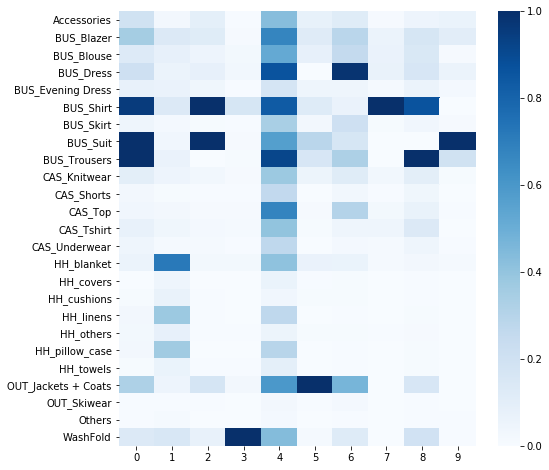

In [106]:
centers = pd.DataFrame(data=m_km.cluster_centers_, columns=df_dumm.columns)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(centers.T, cmap='Blues', yticklabels=centers.columns)

In [107]:
df_clustered = df_dumm.copy()
df_clustered['cluster'] = m_clusters

In [108]:
df_clustered.groupby(['cluster'])['Accessories'].count()

cluster
0    2676
1    2651
2    3604
3    5954
4    1889
5    3935
6    2813
7    3645
8    3259
9    3991
Name: Accessories, dtype: int64

In [109]:
df_clustered.head()

,Accessories,BUS_Blazer,BUS_Blouse,BUS_Dress,BUS_Evening Dress,BUS_Shirt,BUS_Skirt,BUS_Suit,BUS_Trousers,CAS_Knitwear,...,HH_cushions,HH_linens,HH_others,HH_pillow_case,HH_towels,OUT_Jackets + Coats,OUT_Skiwear,Others,WashFold,cluster
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545b9a8bd2cde8871f009f9b,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
545bf6e0d4cde8f935b78a08,0,1,0,0,0,1,0,1,1,0,...,0,1,0,1,0,0,0,0,1,4
545e000cd4cde8f150245542,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,4
5460b54cd3cde8e8394e5f76,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,8
5460ed12d2cde8b8733e41c1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7


In [110]:
df_freq = df_clustered.reset_index()[['customer_db_id', 'cluster']].merge(df_cust[['customer_db_id', 'frequency']])
df_freq = df_freq.loc[df_freq.frequency > 0].drop_duplicates()

In [111]:
df_freq.groupby('cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2473.0,60.684998,65.569682,1.666667,22.600000,39.75000,74.833333,909.0
1,1039.0,102.097899,129.153117,1.000000,24.312500,53.66667,122.833350,908.0
2,2339.0,93.956310,116.043168,1.000000,28.000000,54.33333,112.741050,1198.0
3,2815.0,73.455305,112.216570,1.000000,15.337122,33.25000,77.000000,1000.0
4,1830.0,43.949829,51.156241,0.349156,17.477942,29.85357,51.826187,771.0
5,1780.0,140.415407,145.666321,1.000000,46.830355,91.06250,179.541667,1015.0
6,1604.0,110.613454,121.326370,1.000000,40.500000,73.08117,132.000000,1076.0
7,1883.0,90.179652,125.821126,1.000000,23.333330,48.25000,101.000000,1261.0
8,2129.0,77.597307,101.929658,1.000000,21.000000,42.50000,93.250000,1031.0


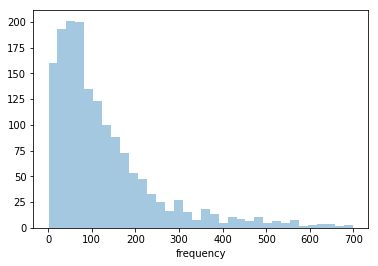

In [112]:
sns.distplot(df_freq.loc[(df_freq.cluster==9) & (df_freq.frequency < 700), 'frequency'], kde=False)

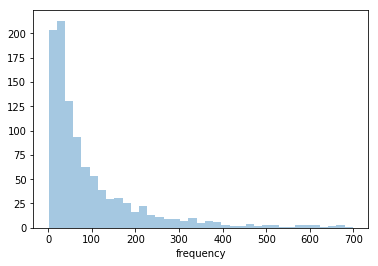

In [113]:
sns.distplot(df_freq.loc[(df_freq.cluster==1) & (df_freq.frequency < 700), 'frequency'], kde=False)

In [114]:
df_clustered = df_clustered.reset_index().merge(df[['customer_db_id', 'NPS_frequency']])

In [115]:
df_nps_cluster = df_clustered.groupby(['cluster', 'NPS_frequency'])['customer_db_id'].nunique().reset_index()
df_nps_cluster_total = df_clustered.loc[~df_clustered.NPS_frequency.isnull()]\
                                    .groupby(['cluster'])['customer_db_id'].nunique()\
                                    .reset_index().rename(columns={'customer_db_id': 'cluster_total'})
df_nps_cluster = df_nps_cluster.merge(df_nps_cluster_total, how='left', on='cluster')
df_nps_cluster['cluster_freq'] = df_nps_cluster.customer_db_id / df_nps_cluster.cluster_total

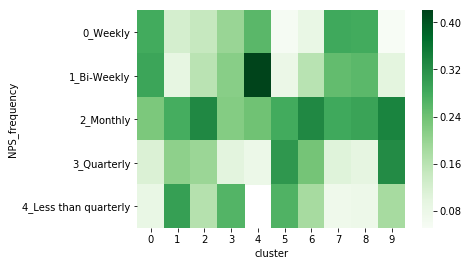

In [116]:
df_nps_cluster_pivot = df_nps_cluster.pivot(index='NPS_frequency', columns='cluster', values='cluster_freq')
sns.heatmap(df_nps_cluster_pivot, cmap='Greens')

In [117]:
# df_clustered.to_csv('data/clustered_customers.csv', index=False)

In [119]:
df = df.merge(df_clustered.reset_index()[['customer_db_id', 'cluster']], on='customer_db_id', how='left')

In [121]:
df.groupby('cluster')['aov'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1713298.0,35.907484,18.937988,0.0,24.738190,31.329780,43.585090,553.226891
1,571470.0,56.710427,40.097160,0.0,30.909490,38.918110,70.377460,1005.275000
2,392831.0,28.843523,12.647985,0.0,20.450660,26.943697,34.649499,198.716700
3,646408.0,28.329628,18.526114,0.0,16.559370,25.311613,32.504040,518.333300
4,10859134.0,54.153392,40.826756,0.0,28.268740,45.837500,70.492070,2247.966387
5,102910.0,33.772093,21.412683,0.0,21.206933,28.612395,40.048610,300.241700
6,265038.0,51.773922,33.796038,0.0,30.691320,41.505220,66.741670,518.741700
7,90849.0,24.930200,12.208456,0.0,18.485294,22.702110,28.625980,189.916000
8,610477.0,33.472757,17.105328,0.0,23.754950,29.442650,38.912011,325.991700


In [41]:
df_nps_products = df.loc[~df.NPS_frequency.isnull()]\
                    .groupby(['NPS_frequency', 'product_group'])['customer_db_id']\
                    .nunique().reset_index()
df_nps_products_total = df.loc[~df.NPS_frequency.isnull()]\
                    .groupby(['product_group'])['customer_db_id']\
                    .nunique().reset_index()\
                    .rename(columns={'customer_db_id': 'product_group_total'})
df_nps_products = df_nps_products.merge(df_nps_products_total, on='product_group', how='left')
df_nps_products['customers_ratio'] = df_nps_products.customer_db_id / df_nps_products.product_group_total
df_nps_products.head()

,NPS_frequency,product_group,customer_db_id,product_group_total,customers_ratio
0,0_Weekly,Accessories,28,136,0.205882
1,0_Weekly,BUS_Blazer,34,256,0.132812
2,0_Weekly,BUS_Blouse,31,195,0.158974
3,0_Weekly,BUS_Dress,55,277,0.198556
4,0_Weekly,BUS_Evening Dress,8,89,0.089888


In [42]:
df_nps_products_pivot = df_nps_products.pivot(index='product_group', columns='NPS_frequency', values='customer_db_id')

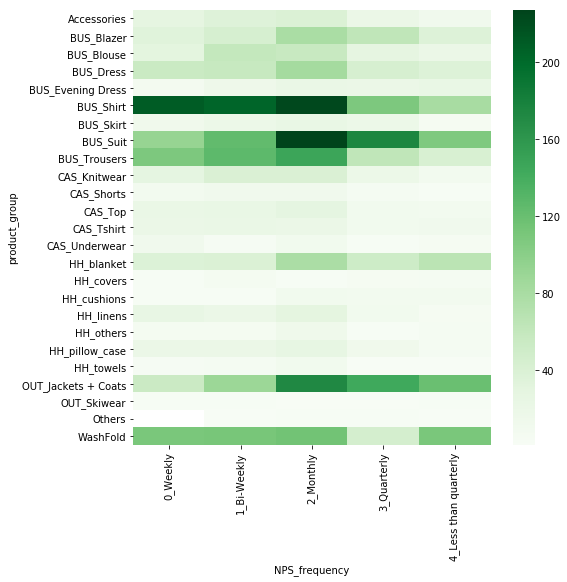

In [43]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_nps_products_pivot, cmap='Greens', yticklabels=df_nps_products_pivot.index)